<a href="https://colab.research.google.com/github/vijayshankarrealdeal/GoogleColab/blob/main/Retino3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U -q kaggle==1.5.8

     |████████████████████████████████| 59 kB 4.3 MB/s 


In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [03:23<00:00, 93.4MB/s]
100% 9.51G/9.51G [03:23<00:00, 50.1MB/s]


In [ ]:
!unzip '/content/aptos2019-blindness-detection.zip'  -d '/content/data/'

In [7]:
import os
os.remove("/content/aptos2019-blindness-detection.zip")

In [20]:
from shutil import copy
copy('/content/drive/MyDrive/Weight Incepv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', '/content/data/')

'/content/data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [68]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

In [9]:
print(os.listdir('/content/data'))

['test.csv', 'test_images', 'sample_submission.csv', 'train_images', 'train.csv']


In [10]:
dir = '/content/data'
IMG_DIM = 299
BATCH_SIZE = 8
CHANNEL_SIZE = 3
NUM_EPOCHS = 60
TRAIN_DIR = 'train_images'
TEST_DIR = 'test_images'
FREEZE_LAYERS = 2
CLASSS = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}
NUM_CLASSS = 5

In [11]:
ROOT_PATH = '/content/data'
TRAIN_PATH = '/content/data/' + TRAIN_DIR 
TEST_PATH = '/content/data/' + TEST_DIR 
dir_path = ROOT_PATH + '/'

In [14]:
df_train = pd.read_csv(ROOT_PATH + '/train.csv')
df_test = pd.read_csv(ROOT_PATH + '/test.csv')

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df_train.id_code, df_train.diagnosis, test_size=0.2,
                                                    random_state=0,)

In [21]:
input = tf.keras.layers.Input(shape =(299,299,3))
base_model = tf.keras.applications.InceptionV3(weights=None, include_top=False, input_tensor=input)
base_model.load_weights('/content/data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [27]:
x = base_model.output
head_model = tf.keras.layers.BatchNormalization()(x)
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = tf.keras.layers.Dense(1024,activation = 'relu')(head_model)
predictions =  tf.keras.layers.Dense(5, activation='softmax')(head_model)
network = tf.keras.Model(inputs = base_model.input,outputs = predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

for layer in network.layers:
    layer.trainable = True
    
print(network.summary())

In [42]:
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = tf.keras.optimizers.SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=False)
network.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [30]:
df_train.id_code = df_train.id_code.apply(lambda x : x +'.png')
df_test.id_code = df_test.id_code.apply(lambda x : x +'.png')
df_train['diagnosis'] = df_train['diagnosis'].astype('str')

In [ ]:
df_train.head()

In [31]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                         validation_split=0.15,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         rotation_range=360,
                                         zoom_range=0.2,
                                         shear_range=0.1)

In [34]:
train_genrator = train_datagen.flow_from_dataframe(
                                                    dataframe=df_train,
                                                    directory= TRAIN_PATH + '/',
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='training',
                                                    shaffle=True,
                                                    seed=0
)
valid_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory= TRAIN_PATH + '/',
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='validation',
                                                    shaffle=True,
                                                    seed=42
                                                    )

Found 3113 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


In [36]:
NUB_TRAIN_STEPS = train_genrator.n // train_genrator.batch_size
NUB_VALID_STEPS = valid_generator.n // valid_generator.batch_size
NUB_TRAIN_STEPS, NUB_VALID_STEPS

(389, 68)

In [37]:
eraly_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)

In [45]:
history = network.fit(train_genrator,
                                     steps_per_epoch=NUB_TRAIN_STEPS,
                                     validation_data=valid_generator,
                                     validation_steps=NUB_VALID_STEPS,
                                     epochs=NUM_EPOCHS,
                                     #shuffle=True,  
                                     callbacks=[eraly_stop, reduce_lr],
                                     verbose=1)

Epoch 1/60
389/389 [==============================] - 598s 2s/step - loss: 1.0675 - accuracy: 0.6409 - val_loss: 0.9176 - val_accuracy: 0.6673
Epoch 2/60
389/389 [==============================] - 601s 2s/step - loss: 0.7885 - accuracy: 0.7163 - val_loss: 0.7250 - val_accuracy: 0.7188
Epoch 3/60
389/389 [==============================] - 596s 2s/step - loss: 0.7434 - accuracy: 0.7327 - val_loss: 0.6918 - val_accuracy: 0.7408
Epoch 4/60
389/389 [==============================] - 594s 2s/step - loss: 0.6775 - accuracy: 0.7491 - val_loss: 0.6295 - val_accuracy: 0.7739
Epoch 5/60
389/389 [==============================] - 600s 2s/step - loss: 0.6424 - accuracy: 0.7597 - val_loss: 0.6794 - val_accuracy: 0.7555
Epoch 6/60
389/389 [==============================] - 605s 2s/step - loss: 0.6042 - accuracy: 0.7755 - val_loss: 0.6654 - val_accuracy: 0.7629

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 7/60
389/389 [==============================] - 607s 2s

In [70]:
(eval_loss, eval_accuracy) = tqdm(network.evaluate(valid_generator, steps=NUB_VALID_STEPS))
print(f'\naccuracy:{eval_accuracy * 100}')
print("Loss: {}".format(eval_loss))

68/68 [==============================] - 79s 1s/step - loss: 0.5198 - accuracy: 0.8051


100%|██████████| 2/2 [00:00<00:00, 13684.52it/s]


accuracy:80.51470518112183
Loss: 0.5197727084159851


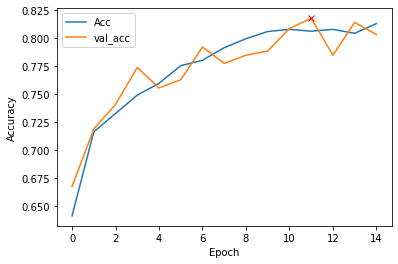

In [71]:
accu = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_accuracy"]), np.max(history.history["val_accuracy"]), marker="x", color="r")
plt.show()

In [72]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255, validation_split=0.2, horizontal_flip=True)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory= TEST_PATH  + '/',
                                                  x_col="id_code",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None,
                                                  seed=0)
print(df_test.shape[0])

Found 1928 validated image filenames.
1928


In [78]:
tta_steps = 5
preds_tta = []
for i in tqdm(range(tta_steps)):
    test_generator.reset()
    preds = network.predict(test_generator, steps=math.ceil(df_test.shape[0]))
    preds_tta.append(preds)

100%|██████████| 5/5 [08:07<00:00, 97.56s/it]


In [82]:
final_pred = np.mean(preds_tta, axis=0)
predicted_class_indices = np.argmax(final_pred, axis=1)
predicted_class_indices

array([2, 2, 4, ..., 2, 3, 2])

In [75]:
network.save_weights("/content/Retinomodel.h5")

In [77]:
copy('/content/Retinomodel.h5','/content/drive/MyDrive/Weight Incepv3/')

'/content/drive/MyDrive/Weight Incepv3/Retinomodel.h5'